In [1]:
import keras
from keras.backend import tensorflow_backend
import keras.backend as K
import tensorflow as tf

# 清空之前model占用的内存
K.clear_session()
tf.reset_default_graph()
session_global = tf.Session()   # 创建一个会话，当上下文管理器退出时会话关闭和资源释放自动完成
# session_global = tf.Session().as_default()  # 创建一个默认会话，当上下文管理器退出时会话并没有关闭
tensorflow_backend.set_session(session_global)
graph = tf.get_default_graph()  # 默认的数据流图DAG

Using TensorFlow backend.


In [2]:
def clean(x):
    x = re.sub("\"", "", x)
    x = re.sub("\s", "", x)  # \s匹配任何空白字符，包括空格、制表符、换页符等
    x = re.sub(",", "，", x)
    return x

In [50]:
import pandas as pd
import os
import csv
import re

with open("DatasetLXH/fewshot_train.csv","w", encoding='utf-8', newline='') as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(['knowledge_id','question','base_code'])
    for filename in [r"DatasetLXH/IT生产知识.xlsx"]:
        df=pd.read_excel(filename, usecols=[0,1,2,4], encoding='utf-8', keep_default_na=False)
        for index, row in df.iterrows():
            lines = []
            kid, pri, sims, base_code = row
            lines.append([kid, clean(pri), base_code])
            for sim in sims.strip().strip("###").split("###"):
                if sim:
                    lines.append([kid, clean(sim), base_code])
            writer.writerows(lines)

with open("DatasetLXH/fewshot_train.csv",encoding='utf-8') as csvfile:
    for line in csvfile:
        if not len(line.split(","))==3 or '' in line.split(","):
            print(line)

In [22]:
sheet2base = {
    "HALO测试内容":"HALOBIGROOMBASE", 
    "差旅测试内容":"CLXTBASE", 
    "HR-π":"HRPBASE", 
    "成本管理平台":"CBGLXTBASE", 
    "场景化费用":"CJHFYXTBASE", 
    "供应商":"GYSGXGLPTBASE", 
    "商业资产":"C2ZGXTBASE"
}
with open("DatasetLXH/fewshot_test.csv","w", encoding='utf-8', newline='') as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(['knowledge_id','question','base_code'])
    for filename in [r"DatasetLXH/HALO_差旅_HR-_成本管理测试集123123.xlsx"]:
        for sheet_name, base_code in sheet2base.items():
            df=pd.read_excel(filename, sheet_name=sheet_name, usecols=[0,3], encoding='utf-8', keep_default_na=False)
            for index, row in df.iterrows():
                lines = []
                query, kid = row
                if kid:
                    lines.append([clean(str(kid)), clean(query), base_code])
                    writer.writerows(lines)

with open("DatasetLXH/fewshot_test.csv",encoding='utf-8') as csvfile:
    for line in csvfile:
        if not len(line.split(","))==3 or '' in line.split(","):
            print(line)

# data = pd.read_csv("DatasetLXH/train.csv",engine='python')
# for index,row in data.iterrows():
#     pass

In [3]:
import pandas as pd
import numpy as np

test = pd.read_csv('DatasetLXH/fewshot_test.csv')       #[:200]
train = pd.read_csv('DatasetLXH/fewshot_train.csv')     #[:200]

In [4]:
train=train[['knowledge_id','question', 'base_code']]
test=test[['knowledge_id','question', 'base_code']]

In [7]:
import os
import keras
from keras.models import Model
from keras.layers import *
from bert4keras.backend import search_layer
from bert4keras.models import build_transformer_model as build_bert_model


root = r"D:\#Pre-trained_Language_Model\weights\bert\chinese_L-12_H-768_A-12"
bert_model = build_bert_model(
    os.path.join(root, "bert_config.json"), 
    os.path.join(root, 'bert_model.ckpt'),
    model='bert'
)   # embed

x1_in = Input(shape=(None,))
x2_in = Input(shape=(None,))
x = bert_model([x1_in, x2_in])
x = Lambda(lambda x: x[:, 0])(x)    # first_token
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
dense_layer = Dense(128, name='dense_layer')(x)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

model=Model(inputs=[x1_in, x2_in], outputs=norm_layer)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, None, 768)    101677056   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 768)          0           model_4[1][0]              

In [8]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Layer
from bert4keras.tokenizers import Tokenizer
tokenizer = Tokenizer(os.path.join(root, 'vocab.txt'))  # 建立分词器

def triplet_loss(model_anchor, model_positive, model_negative, margin):
    distance1 = tf.sqrt(tf.reduce_sum(tf.pow(model_anchor - model_positive, 2), 1, keepdims=True))
    distance2 = tf.sqrt(tf.reduce_sum(tf.pow(model_anchor - model_negative, 2), 1, keepdims=True))
    return tf.reduce_mean(tf.maximum(distance1 - distance2 + margin, 0)) + 1e-9

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sqrt(K.sum(K.square(a-p), axis=-1))
        n_dist = K.sqrt(K.sum(K.square(a-n), axis=-1))
        return K.mean(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

4. Triplet Loss and Training Network

I have constructed the triplet loss and returned the sum of the losses, you can also take its mean. While taking mean u must ensure that u are doing hard negative mining of the **triplets(anchor, positive and negative)** selected.The concept of **Hard negative mining** is well explained in the reference videos shared above.

In [9]:
from keras import backend as K
from keras.backend import tensorflow_backend
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
x1_in = Input(shape=(None,), name="anchor_input")
x2_in = Input(shape=(None,))

x3_in = Input(shape=(None,), name="positive_input")
x4_in = Input(shape=(None,))

x5_in = Input(shape=(None,), name="negative_input")
x6_in = Input(shape=(None,))

# Output for anchor, positive and negative embedding vectors
# The bert_model instance is shared (Siamese network)
emb_a = model([x1_in, x2_in])
emb_p = model([x3_in, x4_in])
emb_n = model([x5_in, x6_in])

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])
# Model that can be trained with anchor, positive negative images
train_model = Model([x1_in, x2_in, x3_in, x4_in, x5_in, x6_in], triplet_loss_layer)

# # BYJ
# train_model = Model([x1_in, x2_in, x3_in, x4_in, x5_in, x6_in], x_a)
# final_loss = triplet_loss(x, x_p, x_n, 0.1)
# train_model.add_loss(final_loss)

train_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None)         0                                            
____________________________________________________________________________________________

In [11]:
import numpy as np
from tqdm import tqdm
maxlen = 512
use_postag = False

unique_train_label=np.array(train['knowledge_id'].unique().tolist())
labels_train=np.array(train['knowledge_id'].tolist())
map_train_label_indices = {label: np.flatnonzero(labels_train == label) for label in unique_train_label}    # 非零元素的索引
# print("1: ", len(unique_train_label))
# print("2: ", map_train_label_indices[33389])

1:  2126
2:  [28343 28344 28345 28346 28347 28348 28349 28350 28351 28352 28353]


In [12]:
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L) if L else 0
    return np.array(
        [
            np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x
            for x in X
        ]
    )

def _trim_input(title,
                t_max_len=30, q_max_len=0, a_max_len=0):
    if use_postag:
        #masked_sent_without_verb, masked_sent_only_verb = mask_sent_by_verb(title)
        masked_sent_without_verb = title
        masked_sent_only_verb = title
        x1, x2 = tokenizer.encode(masked_sent_without_verb, masked_sent_only_verb)
    else:
        x1, x2 = tokenizer.encode(title, maxlen=t_max_len)
        # x1, x2 = tokenizer.encode(title,title)
    if len(x1) > maxlen:
        if use_postag:
            t0_x1, t0_x2 = tokenizer.encode(masked_sent_without_verb, masked_sent_only_verb)
        else:
            t0_x1, t0_x2 = tokenizer.encode(title,)
        q0_x1, q0_x2 = tokenizer.encode('')
        a0_x1, a0_x2 = tokenizer.encode('')

        head_tag_x1, head_tag_x2 = [t0_x1[0]], [t0_x2[0]]
        tail_tag_x1, tail_tag_x2 = [t0_x1[-1]], [t0_x2[-1]]

        t_x1, t_x2 = t0_x1[1:-1], t0_x2[1:-1]
        q_x1, q_x2 = q0_x1[1:-1], q0_x2[1:-1]
        a_x1, a_x2 = a0_x1[1:-1], a0_x2[1:-1]

        t_len = len(t_x1)
        q_len = len(q_x1)
        a_len = len(a_x1)

        if t_max_len > t_len:
            t_new_len = t_len
            a_max_len = a_max_len + math.floor((t_max_len - t_len) / 2)
            q_max_len = q_max_len + math.ceil((t_max_len - t_len) / 2)
        else:
            t_new_len = t_max_len

        if a_max_len > a_len:
            a_new_len = a_len
            q_new_len = q_max_len + (a_max_len - a_len)
        elif q_max_len > q_len:
            a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
            a_new_len = a_max_len
            q_new_len = q_max_len

        x1 = head_tag_x1 + t_x1[:t_new_len] + q_x1[:q_new_len] + a_x1[:a_new_len] + tail_tag_x1
        x2 = head_tag_x2 + t_x2[:t_new_len] + q_x2[:q_new_len] + a_x2[:a_new_len] + tail_tag_x2

    if len(x1) > maxlen:
        print('x1!!!!', len(x1))
    if len(x2) > maxlen:
        print('x2!!!!', len(x2))
    return x1, x2

def compute_input_arrays(input_arrays):
    x1_, x2_ = [], []
    for instance in tqdm(input_arrays):
        x1, x2 = _trim_input(instance[:maxlen], t_max_len=maxlen)
        x1_.append(x1)
        x2_.append(x2)
    x1_ = seq_padding(x1_)
    x2_ = seq_padding(x2_)
    return [x1_, x2_]

In [13]:
def get_triplets(unique_train_label,map_train_label_indices):
      label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
      while len(map_train_label_indices[label_l])<2:
        label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
      a, p = np.random.choice(map_train_label_indices[label_l],2, replace=False)
        
      n = np.random.choice(map_train_label_indices[label_r])
      return a, p, n

def get_triplets_batch(k,train_set,unique_train_label,map_train_label_indices):

    while True:
      idxs_a, idxs_p, idxs_n = [], [], []
      for _ in range(k):
          a, p, n = get_triplets(unique_train_label,map_train_label_indices)
          idxs_a.append(a)
          idxs_p.append(p)
          idxs_n.append(n)

      a=train_set.iloc[idxs_a].values.tolist()
      b=train_set.iloc[idxs_p].values.tolist()
      c=train_set.iloc[idxs_n].values.tolist()

      train_in = []
      train_in.extend(compute_input_arrays(a))
      train_in.extend(compute_input_arrays(b))
      train_in.extend(compute_input_arrays(c)) 

      yield train_in, []  # data, label

# train_data = get_triplets_batch(128,train['question'],unique_train_label,map_train_label_indices)
# for item in train_data:
#     print(item)

In [132]:
with session_global.as_default():
    with session_global.graph.as_default(): # 用with新建一个graph，这样在运行完以及异常退出时就会释放内存
        # Adam= Adam(min_learning_rate)
        train_model.compile(loss=None, optimizer='adam')
        train_model.fit(get_triplets_batch(128,train['question'],unique_train_label,map_train_label_indices), epochs=100,steps_per_epoch=10)

E:\Python\Python37\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output triplet_loss_layer missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to triplet_loss_layer.
  'be expecting any data to be passed to {0}.'.format(name))
100%|██████████| 128/128 [00:00<00:00, 21384.17it/s]Epoch 1/100

100%|██████████| 128/128 [00:00<00:00, 11667.05it/s]


In [ ]:
# with session_global.as_default():
#     with session_global.graph.as_default(): # 用with新建一个graph，这样在运行完以及异常退出时就会释放内存
#         X_train = model.predict(np.array(train['question'].values.tolist()))
#         X_test = model.predict(np.array(test['question'].values.tolist()))

#         y_train = np.array(train['knowledge_id'].values.tolist())
#         y_test = np.array(test['knowledge_id'].values.tolist())

In [48]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import LinearSVC

# knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
# svc = LinearSVC()

# knn.fit(X_train, y_train)
# svc.fit(X_train, y_train)

# y_pred_knn = knn.predict(X_test)
# acc_knn = accuracy_score(y_test, y_pred_knn)
# y_pred_svc = svc.predict(X_test)
# acc_svc = accuracy_score(y_test, y_pred_svc)

# print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.8764113518462008, SVM accuracy = 0.8748855660665242


In [41]:

from sklearn.metrics import classification_report, f1_score
unique_test_base = test['base_code'].unique().tolist()

all_pred_1_list, all_val_1_list = [], []
for base in tqdm(unique_test_base):
    test_data = test[test['base_code']==base]    # test
    querys = test_data["question"].tolist()[:64]
    labels_test = test_data['knowledge_id'].tolist()[:64]
    valid_inputs = compute_input_arrays(querys)
    valid_predictions = []
    valid_predictions.append(
        model.predict(valid_inputs, batch_size=16)
    )
    # print(train['knowledge_id'])
    # print(list(map(lambda x:int(x), labels_test)))

    # candidate_data = train[train['base_code']==base]    # candidate
    candidate_data = train[train['knowledge_id'].isin(list(map(lambda x:int(x[:5]), labels_test)))]    # candidate
    querys_cand = candidate_data["question"]
    labels_cand = candidate_data['knowledge_id'].astype(str).tolist()
    cand_inputs = compute_input_arrays(querys_cand)
    cand_vecs = model.predict(cand_inputs, batch_size=16)  # primary embeddings

    pred_1_list, val_1_list = [], []
    for idx, one in enumerate(valid_predictions[-1]):
        # 正确kid列表
        one_anwser_list = labels_test[idx].split("###")
        one_anwser_list = [str(int(one_a)) for one_a in one_anwser_list]
        # 预测的kid
        dot_list = np.dot(cand_vecs, one)   # 点积
        max_idx = np.argmax(dot_list)
        pred_one = str(int(labels_cand[max_idx]))  
        # top1预测结果
        if one_anwser_list[0] not in labels_cand:
            print(one_anwser_list, " not in candidate set")
            continue
        if pred_one in one_anwser_list:
            val_1_list.append(pred_one)
        else:
            try:
                val_1_list.append(one_anwser_list[0])
                print(
                    "wrong {} pid:{} kid:{}".format(
                        querys[idx], pred_one, one_anwser_list,
                    )
                )
            except:
                print("error: ", idx)
        pred_1_list.append(pred_one)

    print("base: ", base)
    # top1 report 版本0.21.x以上
    report = classification_report(
        val_1_list, pred_1_list, digits=4, output_dict=True
    )
    print("Top1 micro avg", report["accuracy"])
    print("Top1 macro avg", report["macro avg"])
    print("Top1 weighted avg", report["weighted avg"])

    all_pred_1_list.extend(pred_1_list)
    all_val_1_list.extend(val_1_list)

print("ALL")
# top1 report 版本0.21.x以上
report = classification_report(
    all_val_1_list, all_pred_1_list, digits=4, output_dict=True
)
print("Top1 micro avg", report["accuracy"])
print("Top1 macro avg", report["macro avg"])
print("Top1 weighted avg", report["weighted avg"])
f1 = f1_score(all_val_1_list, all_pred_1_list, average="weighted")
if f1 > self.f1:
    print("epoch:{} 当前最佳f1-score！".format(epoch))
    self.f1 = f1
    self.model.save_weights("it_nlu-{name}.h5".format(name=epoch))

100%|██████████| 64/64 [00:00<00:00, 12838.27it/s]

100%|██████████| 27/27 [00:00<00:00, 27183.44it/s]wrong halo平台账号进入后无审图项目 pid:29405 kid:['29388']
wrong halo审图软件升级安装失败 pid:29405 kid:['29401']
wrong halo平台无权限，无法填写会议纪要 pid:32182 kid:['29375']
wrong halou平台增加到郑州项目和华中权限 pid:32187 kid:['29375']
wrong 幸福林带策划：需要halo虚拟样板间下单地址 pid:32187 kid:['29407']
wrong halo更新后如何导出审图意见 pid:29404 kid:['29409']
wrong halo下载异常无法安装 pid:29405 kid:['29401']
wrong 无法打开halo pid:32150 kid:['29377', '29375']
wrong 无法下载halo平台里的图纸 pid:29405 kid:['32173', '32174']
wrong 没有Halo协同平台的权限 pid:32187 kid:['29375']
wrong 如何设置多节点任务提醒 pid:32185 kid:['32115']
wrong halo审图登陆 pid:29401 kid:['29377', '32184']
wrong HALO会议，无法编辑添加会议地点 pid:29397 kid:['32129', '33265']
wrong 登录halo平台任务选项，显示没有该页面权限，电脑提示让我联系it。 pid:32183 kid:['32119']
wrong 需要开通HALO“C3预案团队”权限 pid:29375 kid:['32187']
wrong 因职能工作需要，现申请开通HALO广州公司各项目审核文档权限，请IT同事协助开通，谢谢 pid:32182 kid:['29375']
wrong HALO平台供方权限开通 pid:32187 kid:['29375', '32190']
wrong HALOAPP安装及权限 pid:32187 kid

KeyboardInterrupt: 

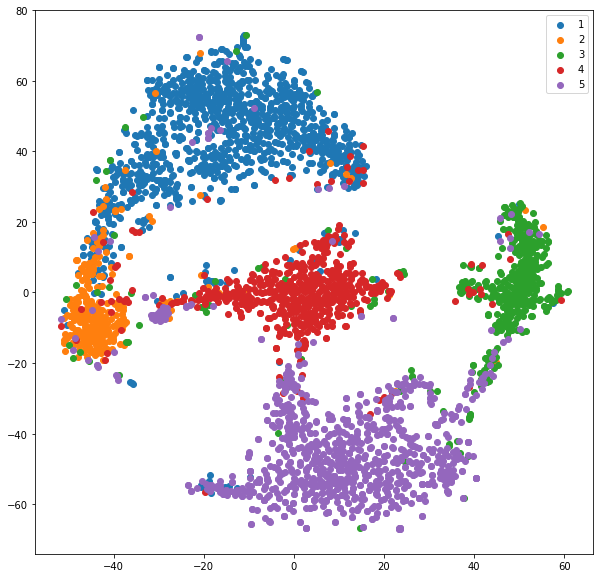

In [50]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_test)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

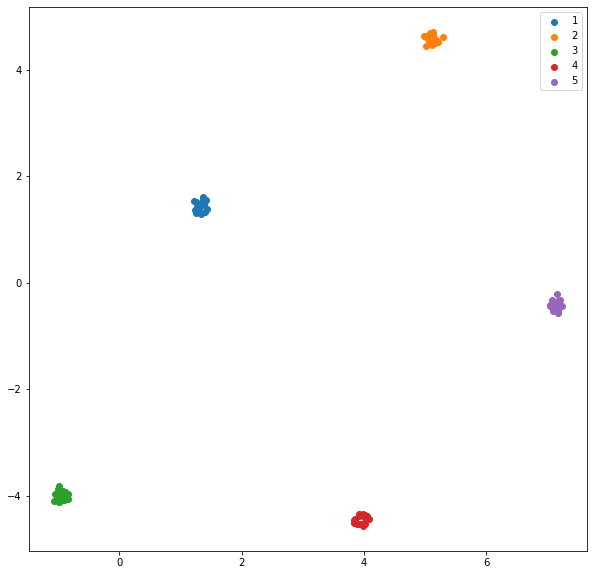

In [51]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_train)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_train)):
    idx = y_train == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));